### All the following cells are runable

In [1]:
# Our setup
import torch
from torch.functional import F

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu" if not torch.cuda.is_available() else "cuda:3"
print(device)

import copy
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from sad_nns.uncertainty import *
from neurops import *

import random
import pandas as pd

ModuleNotFoundError: No module named 'torch'

In [3]:
# set seed
seed = random.randint(0,10000)
torch.manual_seed(seed)
print("Seed of this run: ", seed)

Seed of this run:  1797


In [4]:
train_init = True
verbose = False
filename = 'exp/3-7-2024-1.csv'

use_activation = True
batch_size = 128
epsilon = 0.1
learning_rate = 0.01

growth_epoch = 15
train_epoch = 5
total_epoch = growth_epoch + train_epoch

epochs = np.arange(total_epoch)
results = pd.DataFrame()
results['epoch'] = epochs

In [4]:
# for saving activations
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [5]:
init_model = ModSequential(
        # ModConv2d(in_channels=3, out_channels=8, kernel_size=7, padding=1),
        # ModConv2d(in_channels=8, out_channels=16, kernel_size=7, padding=1),
        # ModConv2d(in_channels=16, out_channels=16, kernel_size=5),
        # ModLinear(64, 32),
        # ModLinear(32, 10, nonlinearity=""),
        # ModLinear(6400, 64),
        ModLinear(784, 64),
        ModLinear(64, 64),
        ModLinear(64, 64),
        ModLinear(64, 10,nonlinearity=""),
        track_activations=False,
        track_auxiliary_gradients=True,
    #    input_shape = (3072)
    #    input_shape = (3, 32, 32)
        input_shape=(784)
        # input_shape=(1,28,28)
    ).to(device)
optimizer = torch.optim.SGD(init_model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# manual save of activation
for i in range(len(init_model)-1):
    init_model[i].register_forward_hook(get_activation(str(i)))

# print("This model has {} effective parameters.".format(model.parameter_count(masked = False)))
# print("The conversion factor of this model is {} after layer {}.".format(model.conversion_factor, model.conversion_layer))
    
for j in range(len(init_model)):
    print("Layer {} weight matrix {}".format(j, init_model[j].weight.size()))
print("The model now has {} effective parameters.".format(init_model.parameter_count(masked = False)))

Layer 0 weight matrix torch.Size([64, 784])
Layer 1 weight matrix torch.Size([64, 64])
Layer 2 weight matrix torch.Size([64, 64])
Layer 3 weight matrix torch.Size([10, 64])
The model now has 59210 effective parameters.


In [6]:
dataset = datasets.MNIST('../data', train=True, download=True,
                     transform=transforms.Compose([ 
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)),
                            # transforms.Resize((14,14))
                            transforms.Resize((28,28)),
                            transforms.Lambda(lambda x: torch.flatten(x))
                        ]))
# dataset = datasets.CIFAR10('../data', train=True, download=True,
#                      transform=transforms.Compose([ 
#                             transforms.ToTensor(),
#                             transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
#                             # transforms.Resize((14,14))
#                             # transforms.Resize((28,28)),
#                             # transforms.Lambda(lambda x: torch.flatten(x))
#                         ]))
train_set, val_set = torch.utils.data.random_split(dataset, lengths=[int(0.9*len(dataset)), int(0.1*len(dataset))])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)),
                            # transforms.Resize((14,14))
                            transforms.Resize((28,28)),
                            transforms.Lambda(lambda x: torch.flatten(x))
                        ])),
    batch_size=batch_size, shuffle=True)

# test_loader = torch.utils.data.DataLoader(
#     datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
#                             transforms.ToTensor(),
#                             transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
#                             # transforms.Resize((14,14))
#                             # transforms.Resize((28,28)),
#                             # transforms.Lambda(lambda x: torch.flatten(x))
#                         ])),
#     batch_size=batch_size, shuffle=True)

def train(model, train_loader, optimizer, criterion, epochs=10, val_loader=None, verbose=True):
    model.train()

    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0 and verbose:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        
        correct = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)   
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            # print(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()
        train_acc = 100. * correct / len(train_loader.dataset)
        train_accs.append(train_acc)

        if val_loader is not None:
            if verbose:
                print("Validation: ", end = "")
            ta = test(model, val_loader, criterion, verbose=verbose)
            test_accs.append(ta)

    return train_accs, test_accs

def test(model, test_loader, criterion, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    if verbose:
        print('Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    
    return 100. * correct / len(test_loader.dataset)

In [29]:
if train_init:
    train_acc,test_acc = train(init_model, train_loader, optimizer, criterion, epochs=total_epoch, val_loader=val_loader, verbose=verbose)
    results['Initial Train Accuracy'] = train_acc
    results['Initial Test Accuracy'] = test_acc

-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-------------------------------------
True
-----------

KeyboardInterrupt: 

In [6]:
# need to set the seed before initialization of layers and models
torch.manual_seed(seed)

# regenerate model
layers = []
for layer in init_model:
    if isinstance(layer, ModConv2d):
        layers.append(ModConv2d(in_channels=layer.in_channels, 
                                out_channels=layer.out_channels, 
                                kernel_size=layer.kernel_size[0], 
                                padding=layer.padding[0]))
    elif isinstance(layer, ModLinear):
        layers.append(ModLinear(layer.in_features, layer.out_features, nonlinearity=layer.nonlinearity))
    else:
        print("not NORTH custom layer")
        
growth_model = ModSequential(
                *layers,
                track_activations=init_model.track_activations,
                track_auxiliary_gradients=init_model.track_auxiliary_gradients,
                input_shape = init_model.input_shape
            ).to(device)

growth_optimizer = torch.optim.SGD(growth_model.parameters(), lr=learning_rate)
growth_criterion = torch.nn.CrossEntropyLoss()

# manual save of activation
for i in range(len(growth_model)-1):
    growth_model[i].register_forward_hook(get_activation(str(i)))

for j in range(len(growth_model)):
    print("Layer {} weight matrix {}".format(j, growth_model[j].weight.size()))
print("The model now has {} effective parameters.".format(growth_model.parameter_count(masked = False)))

NameError: name 'torch' is not defined

In [7]:
# growth_model[0].weight

In [10]:
initial_scores = []
train_accs = []
test_accs = []

if use_activation:
    train_acc,test_acc = train(growth_model, train_loader, growth_optimizer, growth_criterion, epochs=1, val_loader=val_loader, verbose=verbose)
    train_accs += train_acc
    test_accs += test_acc

for iter in range(growth_epoch):
    for i in range(len(growth_model)-1):
        # print("The size of activation of layer {}: {}".format(i, modded_model_grow.activations[str(i)].shape))
        # print("The size of my activation of layer {}: {}".format(i, activation[str(i)].shape))
        #score = orthogonality_gap(modded_model_grow.activations[str(i)])
        max_rank = growth_model[i].width()
        # score = NORTH_score(modded_model_grow.activations[str(i)], batchsize=batch_size)
        score = NORTH_score(growth_model[i].weight, batchsize=1, threshold=epsilon)
        # score = NORTH_score_alter(activation[str(i)], threshold=epsilon)
        # score = NORTH_score(modded_model_grow[i].weight, batchsize=batch_size)
        if iter == 0:
            initial_scores.append(score)
        initScore = 0.97 * initial_scores[i]
        to_add = max(0, int(growth_model[i].weight.size()[0] * (score - initScore)))
        print("Layer {} score: {}/{}, neurons to add: {}".format(i, score, max_rank, to_add))

        # "iterative_orthogonalization", "kaiming_uniform", and "autoinit" are the three options in function north_select, "autoinit" not working
        growth_model.grow(i, to_add, fanin_weights="kaiming_uniform", 
                               optimizer=optimizer)
       
    print("The grown model now has {} effective parameters.".format(growth_model.parameter_count(masked = False)))
    print("Validation after growing: ", end = "")
    test(growth_model, val_loader, criterion, verbose=verbose)
    train_acc,test_acc = train(growth_model, train_loader, growth_optimizer, growth_criterion, epochs=1, val_loader=val_loader, verbose=verbose)
    train_accs += train_acc
    test_accs += test_acc
if use_activation:
    train_acc,test_acc = train(growth_model, train_loader, growth_optimizer, growth_criterion, epochs=train_epoch-1, val_loader=val_loader, verbose=verbose)
else:
    train_acc,test_acc = train(growth_model, train_loader, growth_optimizer, growth_criterion, epochs=train_epoch, val_loader=val_loader, verbose=verbose)
train_accs += train_acc
test_accs += test_acc

test(growth_model, val_loader, criterion)
for j in range(len(growth_model)):
    print("Layer {} weight matrix after growth {}".format(j, growth_model[j].weight.size()))
print("The grown model now has {} effective parameters.".format(growth_model.parameter_count(masked = False)))


results['Growth Train Accuracy'] = train_accs
results['Growth Test Accuracy'] = test_accs

Layer 0 score: 1.0/8, neurons to add: 0
Layer 1 score: 2.0/16, neurons to add: 0
Layer 2 score: 1.875/16, neurons to add: 0
Layer 3 score: 0.125/64, neurons to add: 0
Layer 4 score: 0.125/64, neurons to add: 0
Layer 5 score: 0.125/64, neurons to add: 0
The grown model now has 432522 effective parameters.
Validation after growing: Layer 0 score: 1.0/8, neurons to add: 0
Layer 1 score: 2.0/16, neurons to add: 0
Layer 2 score: 1.875/16, neurons to add: 0
Layer 3 score: 1.0/64, neurons to add: 56
Layer 4 score: 1.0/64, neurons to add: 56
Layer 5 score: 0.625/64, neurons to add: 32
The grown model now has 432522 effective parameters.
Validation after growing: Layer 0 score: 1.0/8, neurons to add: 0
Layer 1 score: 2.0/16, neurons to add: 0
Layer 2 score: 1.75/16, neurons to add: 0
Layer 3 score: 1.0/120, neurons to add: 105
Layer 4 score: 0.875/120, neurons to add: 90
Layer 5 score: 0.75/96, neurons to add: 60
The grown model now has 432522 effective parameters.
Validation after growing: Lay

In [11]:
# need to set the seed before initialization of layers and models
torch.manual_seed(seed)

# regenerate model
layers = []
for layer in growth_model:
    if isinstance(layer, ModConv2d):
        layers.append(ModConv2d(in_channels=layer.in_channels, 
                                out_channels=layer.out_channels, 
                                kernel_size=layer.kernel_size[0], 
                                padding=layer.padding[0]))
    elif isinstance(layer, ModLinear):
        layers.append(ModLinear(layer.in_features, layer.out_features, nonlinearity=layer.nonlinearity))
    else:
        print("not NORTH custom layer")
        
final_model = ModSequential(
                *layers,
                track_activations=growth_model.track_activations,
                track_auxiliary_gradients=growth_model.track_auxiliary_gradients,
                input_shape = growth_model.input_shape
            ).to(device)

final_optimizer = torch.optim.SGD(final_model.parameters(), lr=learning_rate)
final_criterion = torch.nn.CrossEntropyLoss()

# manual save of activation
for i in range(len(final_model)-1):
    final_model[i].register_forward_hook(get_activation(str(i)))

for j in range(len(final_model)):
    print("Layer {} weight matrix {}".format(j, final_model[j].weight.size()))
print("The model now has {} effective parameters.".format(final_model.parameter_count(masked = False)))

Layer 0 weight matrix torch.Size([8, 3, 7, 7])
Layer 1 weight matrix torch.Size([16, 8, 7, 7])
Layer 2 weight matrix torch.Size([16, 16, 5, 5])
Layer 3 weight matrix torch.Size([23637, 6400])
Layer 4 weight matrix torch.Size([7293, 23637])
Layer 5 weight matrix torch.Size([2729, 7293])
Layer 6 weight matrix torch.Size([10, 2729])
The model now has 343638864 effective parameters.


In [12]:
# final_model[0].weight

In [13]:
train_acc,test_acc = train(final_model, train_loader, final_optimizer, final_criterion, epochs=total_epoch, val_loader=val_loader, verbose=verbose)
results['Final Train Accuracy'] = train_acc
results['Final Test Accuracy'] = test_acc

In [14]:
# results

,epoch,Initial Train Accuracy,Initial Test Accuracy,Growth Train Accuracy,Growth Test Accuracy,Final Train Accuracy,Final Test Accuracy
0,0,14.073333,13.86,13.693333,13.84,26.031111,25.54
1,1,23.902222,23.62,24.495556,23.44,28.706667,27.94
2,2,29.786667,29.18,26.973333,26.38,38.762222,38.16
3,3,35.320000,33.84,27.577778,27.36,42.635556,41.56
4,4,38.160000,37.06,27.913333,26.90,45.377778,44.72
5,5,39.473333,39.60,28.222222,27.38,46.673333,44.50
6,6,39.368889,38.12,28.315556,27.64,48.348889,46.06
7,7,41.977778,40.36,28.742222,28.12,48.102222,45.10
8,8,37.244444,36.14,29.102222,28.48,55.160000,50.88
9,9,42.928889,42.56,29.426667,28.74,56.806667,51.38


In [15]:
results.to_csv(filename)

<Axes: >

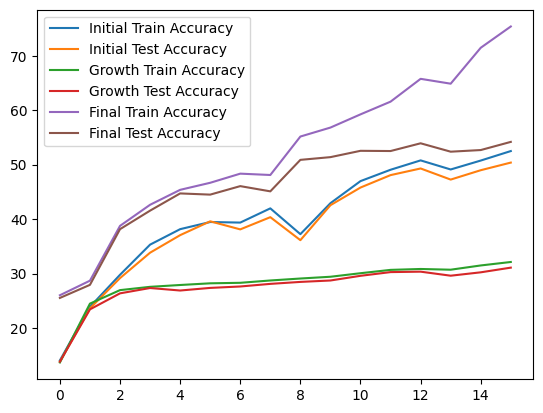

In [16]:
results.iloc[:,1:].plot()

In [17]:
def combine_plot(basepath, indexes, col_names):
    dfs = []
    for i in range(len(indexes)):
        name = basepath + str(indexes[0]) + ".csv"
        dfs.append(pd.read_csv(name))
    
    df = pd.concat(dfs, axis=1)
   
    combined_result = pd.DataFrame()
    for i in range(len(col_names)):
        combined_result[col_names[i]] = df[col_names[i]].mean(axis=1)
    combined_result.plot()

    return combined_result

In [18]:
# col_names = ['Initial Train Accuracy', 'Initial Test Accuracy', 'Growth Train Accuracy', 'Growth Test Accuracy', 'Final Train Accuracy', 'Final Test Accuracy']
# cr = combine_plot("exp/2-15-2024-", [1,2,3], col_names)
# cr

<Axes: >

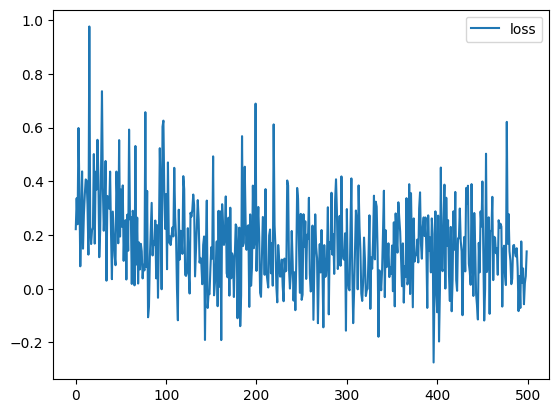

In [7]:
results = pd.read_csv("test.csv")
results.iloc[:,1:].plot()

In [10]:
# t = pd.DataFrame(columns=['epochs', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10'])
bs = [1, 1, 4, 5, 2, 4, 5, 4, 9, 7, 10]
t = pd.concat([pd.DataFrame([bs], columns=t.columns), t], ignore_index=True)

In [11]:
t

,epochs,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10
0,1,1,4,5,2,4,5,4,9,7,10
1,0,2,4,5,2,4,5,4,9,7,10


In [12]:
b = [2, 3]
b.insert(0, 1)
b

[1, 2, 3]

In [6]:
t = pd.DataFrame(columns=['epochs', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10'])
for i in range(5):
    bs = np.ones(11) * i
    t = pd.concat([t, pd.DataFrame([bs], columns=t.columns)], ignore_index=True)
t

/tmp/ipykernel_457272/3040888949.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  t = pd.concat([t, pd.DataFrame([bs], columns=t.columns)], ignore_index=True)


,epochs,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
4,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
